<a href="https://colab.research.google.com/github/Alan240124/Alan/blob/main/Modelo_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Criando a Classe do Dataset

In [7]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HeartDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert("L")  # Converter para grayscale
        mask = Image.open(mask_path).convert("L")    # Converter para grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# Diretórios das imagens e máscaras
image_dir = '/content/drive/MyDrive/DataSet3/images'  # Substitua pelo caminho real
mask_dir = '/content/drive/MyDrive/DataSet3/masks'    # Substitua pelo caminho real

# Transformação (exemplo: converter para tensor)
#transform = transforms.ToTensor()
# Transforma as imagens para tensor e normaliza
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensione conforme necessário
    transforms.ToTensor(),
])

# Criação do dataset e do DataLoader
dataset = HeartDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Exibir algumas informações do dataset
print(f"Total de imagens no dataset: {len(dataset)}")

# Exemplo de iteração pelo DataLoader
for images, masks in dataloader:
    print(f"Tamanho do batch de imagens: {images.shape}")
    print(f"Tamanho do batch de máscaras: {masks.shape}")
    break  # Apenas um batch para demonstração




Total de imagens no dataset: 9
Tamanho do batch de imagens: torch.Size([4, 1, 256, 256])
Tamanho do batch de máscaras: torch.Size([4, 1, 256, 256])


Implementação da U_net

In [2]:
import torch.nn as nn
import torch

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.conv_last(d1))

# Inicializar o modelo e definir o otimizador e a função de perda
model = UNet()
criterion = nn.BCELoss()  # Usamos BCELoss para segmentação binária
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Teste do Modelo

In [9]:
# Configuração do dispositivo (GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loop de treinamento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}")

    # Salva o modelo após cada epoch
    torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")


Epoch [1/10], Loss: 0.5064326723416647
Epoch [2/10], Loss: 0.5487156907717387
Epoch [3/10], Loss: 0.5333487093448639
Epoch [4/10], Loss: 0.38188833991686505
Epoch [5/10], Loss: 0.33559205134709674
Epoch [6/10], Loss: 0.24848535160223642
Epoch [7/10], Loss: 0.16012088457743326
Epoch [8/10], Loss: 0.12165869772434235
Epoch [9/10], Loss: 0.12904474139213562
Epoch [10/10], Loss: 0.12135829031467438


Total de imagens no dataset: 8
Tamanho do batch de imagens: torch.Size([4, 1, 256, 256])
Tamanho do batch de máscaras: torch.Size([4, 1, 256, 256])


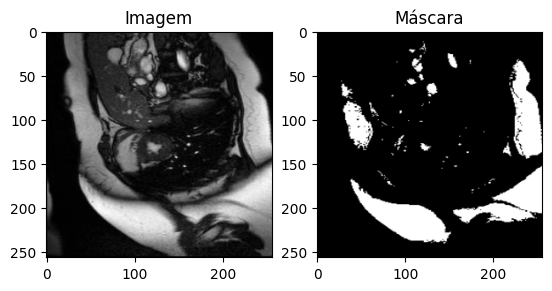

In [10]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class HeartDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        # Validação para garantir que o número de imagens e máscaras seja o mesmo
        assert len(self.images) == len(self.masks), "Número de imagens e máscaras não corresponde."

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert("L")  # Converter para grayscale
        mask = Image.open(mask_path).convert("L")    # Converter para grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Diretórios das imagens e máscaras
image_dir = '/content/drive/MyDrive/Coracao_DataSet/images'  # Substitua pelo caminho real
mask_dir = '/content/drive/MyDrive/Coracao_DataSet/masks'    # Substitua pelo caminho real

# Transformação (exemplo: converter para tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensione conforme necessário
    transforms.ToTensor(),
])

# Criação do dataset e do DataLoader
dataset = HeartDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Exibir algumas informações do dataset
print(f"Total de imagens no dataset: {len(dataset)}")

# Visualização de algumas imagens e máscaras
def show_image_and_mask(image, mask):
    image = image.squeeze(0).numpy()  # Remover o canal de cor
    mask = mask.squeeze(0).numpy()    # Remover o canal de cor
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Imagem')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara')
    plt.show()

# Exemplo de iteração pelo DataLoader
for images, masks in dataloader:
    print(f"Tamanho do batch de imagens: {images.shape}")
    print(f"Tamanho do batch de máscaras: {masks.shape}")

    # Exibindo a primeira imagem e máscara do batch
    show_image_and_mask(images[0], masks[0])
    break  # Apenas um batch para demonstração


Total de imagens no dataset: 8
Tamanho do batch de imagens: torch.Size([4, 1, 256, 256])
Tamanho do batch de máscaras: torch.Size([4, 1, 256, 256])
Imagem 1 - Dimensão: torch.Size([1, 256, 256])
Máscara 1 - Dimensão: torch.Size([1, 256, 256])


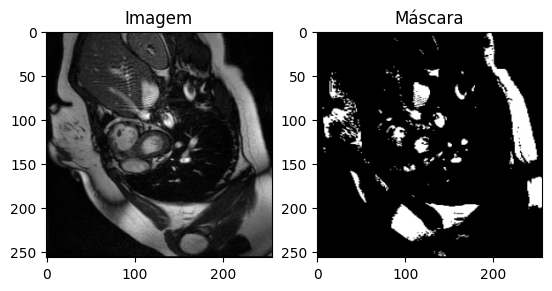

Imagem 2 - Dimensão: torch.Size([1, 256, 256])
Máscara 2 - Dimensão: torch.Size([1, 256, 256])


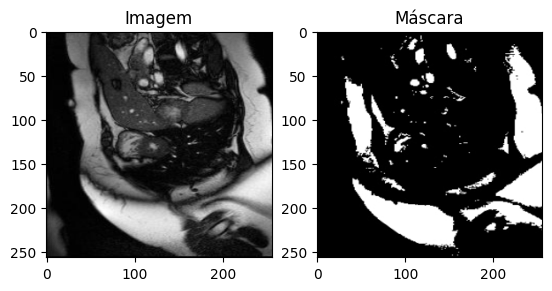

Imagem 3 - Dimensão: torch.Size([1, 256, 256])
Máscara 3 - Dimensão: torch.Size([1, 256, 256])


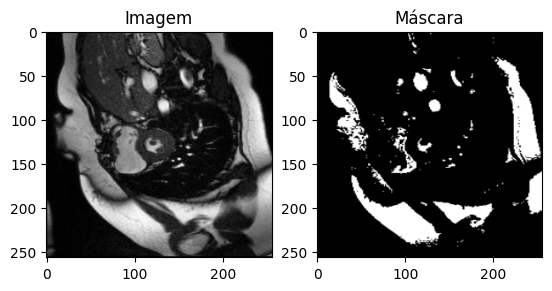

Imagem 4 - Dimensão: torch.Size([1, 256, 256])
Máscara 4 - Dimensão: torch.Size([1, 256, 256])


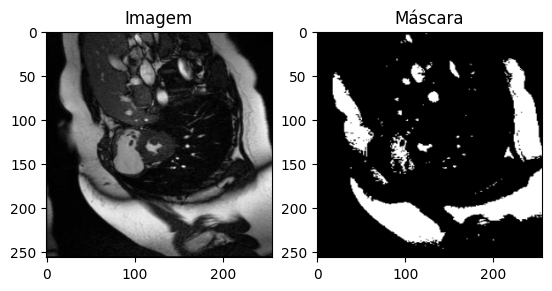

In [11]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class HeartDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        # Validação para garantir que o número de imagens e máscaras seja o mesmo
        assert len(self.images) == len(self.masks), f"Erro: {len(self.images)} imagens e {len(self.masks)} máscaras encontradas. Eles devem corresponder."

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Verificação se os arquivos realmente existem e são acessíveis
        assert os.path.exists(image_path), f"Erro: Imagem não encontrada em {image_path}"
        assert os.path.exists(mask_path), f"Erro: Máscara não encontrada em {mask_path}"

        image = Image.open(image_path).convert("L")  # Converter para grayscale
        mask = Image.open(mask_path).convert("L")    # Converter para grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Validação de tamanho de imagem e máscara
        assert image.size() == mask.size(), "Erro: Dimensões da imagem e da máscara não correspondem."

        return image, mask

# Diretórios das imagens e máscaras
image_dir = '/content/drive/MyDrive/Coracao_DataSet/images'  # Substitua pelo caminho real
mask_dir = '/content/drive/MyDrive/Coracao_DataSet/masks'    # Substitua pelo caminho real

# Transformação: Redimensionamento, conversão para tensor e normalização
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensione conforme necessário
    transforms.ToTensor(),
])

# Criação do dataset e do DataLoader
dataset = HeartDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Exibir algumas informações do dataset
print(f"Total de imagens no dataset: {len(dataset)}")

# Função para mostrar imagem e máscara lado a lado
def show_image_and_mask(image, mask):
    image = image.squeeze(0).numpy()  # Remover o canal de cor
    mask = mask.squeeze(0).numpy()    # Remover o canal de cor
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Imagem')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara')
    plt.show()

# Exemplo de iteração pelo DataLoader
for images, masks in dataloader:
    print(f"Tamanho do batch de imagens: {images.shape}")
    print(f"Tamanho do batch de máscaras: {masks.shape}")

    # Validar o formato e o conteúdo do batch
    for i in range(len(images)):
        print(f"Imagem {i+1} - Dimensão: {images[i].shape}")
        print(f"Máscara {i+1} - Dimensão: {masks[i].shape}")
        # Exibir a primeira imagem e máscara do batch
        show_image_and_mask(images[i], masks[i])

    break  # Apenas um batch para demonstração


In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import jaccard_score

# Funções de métricas de segmentação
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice


In [23]:
import os
from PIL import Image

class HeartDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.startswith("image")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = f'mask_{img_name}'

        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convertemos a máscara para escala de cinza

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [24]:
# Definindo transformações e dataloader
transform = transforms.ToTensor()
test_dataset = HeartDataset(images_dir='/content/drive/MyDrive/Coracao_DataSet/images', masks_dir='/content/drive/MyDrive/Coracao_DataSet/masks', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

class HeartDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        mask_name = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")  # Assuming binary masks (1 channel)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

val_dataset = HeartDataset('/content/drive/MyDrive/Coracao_DataSet/images',
                           '/content/drive/MyDrive/Coracao_DataSet/masks',
                           transform=transform)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
